In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import f1_score
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Embedding, LayerNormalization, Dropout, MultiHeadAttention, GlobalAveragePooling1D
from tensorflow.keras.models import Model
from tensorflow.keras.layers import TextVectorization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
import re

# GPU 메모리 최적화
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
print(f"{len(tf.config.list_physical_devices('GPU'))} Physical GPUs, memory growth enabled")

# 1. 데이터 불러오기 및 컬럼명 정리
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')
test_df = test_df.rename(columns={'text': 'conversation', 'idx': 'file_name'})

# 2. 텍스트 전처리 및 클래스명 통일
def clean_text(text):
    text = re.sub(r'\s+', ' ', str(text).strip())
    return text

def clean_class(x):
    return x.replace(' ', '').replace('대화', '')

train_df['conversation'] = train_df['conversation'].apply(clean_text)
test_df['conversation'] = test_df['conversation'].apply(clean_text)
train_df['class'] = train_df['class'].apply(clean_class)

# 3. 클래스 매핑
custom_classes = ['협박', '갈취', '직장내괴롭힘', '기타괴롭힘', '일반']
class2idx = {c: i for i, c in enumerate(custom_classes)}
idx2class = {i: c for i, c in enumerate(custom_classes)}
train_df['target'] = train_df['class'].map(class2idx)

# 4. 특수 토큰 추가
train_df['conversation'] = "<start> " + train_df['conversation'].astype(str) + " <extract>"
test_df['conversation'] = "<start> " + test_df['conversation'].astype(str) + " <extract>"

# 5. 데이터 분리
X = train_df['conversation'].values
y = train_df['target'].values
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# 6. 텍스트 벡터화
VOCAB_SIZE = 20000
MAX_LEN = 128
vectorize_layer = TextVectorization(
    max_tokens=VOCAB_SIZE,
    output_mode='int',
    output_sequence_length=MAX_LEN,
    standardize=None
)
vectorize_layer.adapt(X_train)

# 7. Positional Embedding
class PositionalEmbedding(tf.keras.layers.Layer):
    def __init__(self, max_len, embed_dim):
        super().__init__()
        self.token_emb = Embedding(VOCAB_SIZE, embed_dim)
        self.pos_emb = Embedding(max_len, embed_dim)
        self.max_len = max_len

    def call(self, x):
        positions = tf.range(start=0, limit=self.max_len, delta=1)
        pos_embeddings = self.pos_emb(positions)
        tok_embeddings = self.token_emb(x)
        return tok_embeddings + pos_embeddings

# 8. GPT-1 Block (메모리 절약형)
class GPTBlock(tf.keras.layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.2):
        super().__init__()
        self.att = MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim, dropout=rate)
        self.ffn = tf.keras.Sequential([
            Dense(ff_dim, activation='gelu'),
            Dropout(rate),
            Dense(embed_dim)
        ])
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.dropout1 = Dropout(rate)
        self.dropout2 = Dropout(rate)

    def call(self, x, training=False):
        seq_len = tf.shape(x)[1]
        mask = tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
        mask = tf.reshape(mask, (1, 1, seq_len, seq_len))
        attn_output = self.att(x, x, attention_mask=mask)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(x + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

# 9. GPT-1 분류 모델 정의 (메모리 절약형)
def create_gpt1_classifier(vocab_size, max_len, embed_dim, num_heads, ff_dim, num_layers, num_classes):
    inputs = Input(shape=(1,), dtype=tf.string)
    x = vectorize_layer(inputs)
    x = PositionalEmbedding(max_len, embed_dim)(x)
    for _ in range(num_layers):
        x = GPTBlock(embed_dim, num_heads, ff_dim)(x)
    x = GlobalAveragePooling1D()(x)
    x = Dropout(0.5)(x)
    outputs = Dense(num_classes, activation='softmax', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
    model = Model(inputs, outputs)
    return model

# 10. 클래스 가중치
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights_dict = {i: w for i, w in enumerate(class_weights)}

# 11. 하이퍼파라미터 (메모리 절약형)
EMBED_DIM = 256
NUM_HEADS = 4
FF_DIM = 512
NUM_LAYERS = 4
BATCH_SIZE = 16

# 학습률 스케줄링
lr_schedule = tf.keras.optimizers.schedules.CosineDecayRestarts(
    initial_learning_rate=2e-4,
    first_decay_steps=1000,
    t_mul=2.0,
    alpha=0.01
)

model = create_gpt1_classifier(
    vocab_size=VOCAB_SIZE,
    max_len=MAX_LEN,
    embed_dim=EMBED_DIM,
    num_heads=NUM_HEADS,
    ff_dim=FF_DIM,
    num_layers=NUM_LAYERS,
    num_classes=len(custom_classes)
)

model.compile(
    optimizer=Adam(learning_rate=lr_schedule),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

X_train_tensor = tf.convert_to_tensor(X_train.reshape(-1, 1))
X_val_tensor = tf.convert_to_tensor(X_val.reshape(-1, 1))

history = model.fit(
    X_train_tensor,
    y_train,
    validation_data=(X_val_tensor, y_val),
    epochs=30,
    batch_size=BATCH_SIZE,
    class_weight=class_weights_dict,
    callbacks=[early_stopping]
)

# 검증 데이터 F1 Score
print("\n[Validation F1 Score 계산]")
y_val_pred = model.predict(X_val_tensor).argmax(axis=1)
val_f1 = f1_score(y_val, y_val_pred, average='macro')
print(f"Validation F1 Score (Macro): {val_f1:.4f}")

# 테스트 데이터 예측
print("\n[테스트 데이터 예측]")
X_test = test_df['conversation'].values
X_test_tensor = tf.convert_to_tensor(X_test.reshape(-1, 1))
y_pred = model.predict(X_test_tensor).argmax(axis=1)

# 예측 결과 분포 확인
from collections import Counter
print("\n예측 클래스 분포:")
class_names = [idx2class[i] for i in y_pred]
print(Counter(class_names))

# 제출 파일 생성 (숫자 target, 컬럼명 idx/target)
submission_3 = pd.DataFrame({
    'idx': test_df['file_name'],
    'target': y_pred
})
submission_3.to_csv('submission_3.csv', index=False)


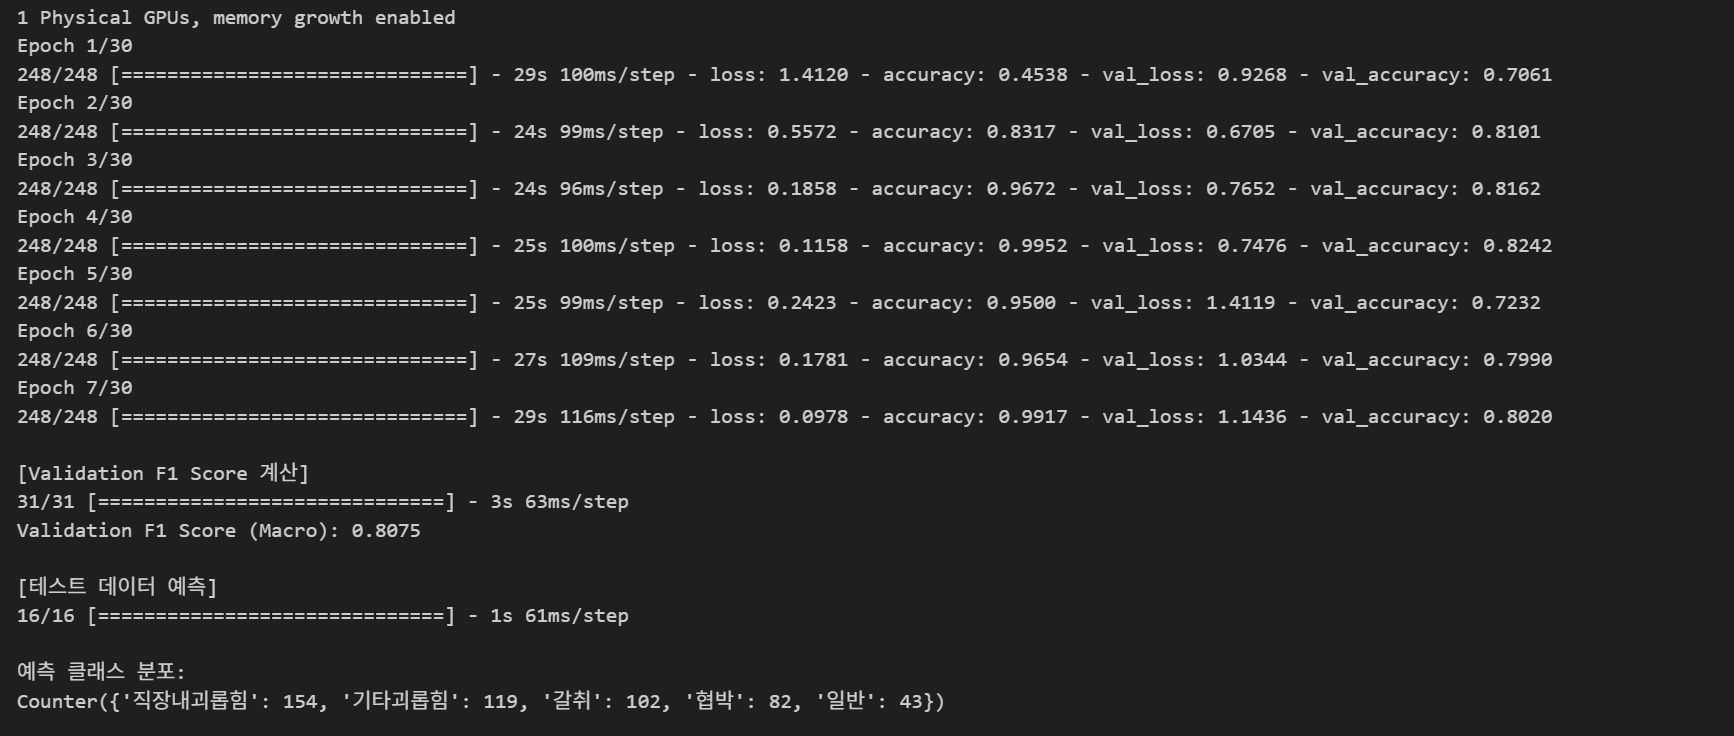